# Chapter 3 - Classification in MNIST
Refiz as atividades citadas no livro, buscando não segui-lo à risca e procurando ler a documentação das funções utilizadas. 

# Imports

In [47]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import sklearn

#imports de funções/objetos específicos
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler

# Inicialização

In [3]:
numberMNIST = fetch_openml('mnist_784',return_X_y=False)

In [20]:
#Leitura do dataset para DataFrame
dataset = numberMNIST.data     #Obs: segundo documentação, 0:60000 = training set; 60000: = test set
labels = numberMNIST.target    #Ou seja, já vem pronto, "embaralhado"!

X_train, X_test, Y_train, Y_test = dataset[:60000], dataset[60000:], labels[:60000], labels[60000:]
Y_train_is4 = (Y_train == '4')
Y_test_is4 = (Y_test == '4')


# Imagem dos Números

In [5]:
some_digit = X_train[9]
some_digit_image = some_digit.reshape(28,28)


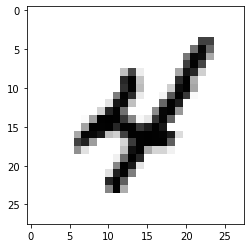

In [6]:
plt.imshow(some_digit_image, cmap=mpl.cm.binary,interpolation="nearest")

# Algoritmo de Classificação - 4's reader Binário (SGD)

In [419]:
#Aplicação de Algoritmo de Classificação BINÁRIO
sgd_BinClassf = SGDClassifier(random_state=42, tol=-np.infty, max_iter=10)  #max_iter peq pq binário, provavelmente!

sgd_BinClassf.fit(X_train, Y_train_is4)
Y_pred = sgd_classf.predict(X_test)


# Refinamento de dados: sklearn metrics
### Precision and Recall

In [431]:
Y_predCrossed = cross_val_predict(sgd_BinClassf, X_train, Y_train_is4, cv=5, method="predict")

In [432]:
#Resultado Final
acc = precision_score(Y_predCrossed, Y_train_is4)
acc

0.8945566586785347

In [433]:
rec = recall_score(Y_predCrossed, Y_train_is4)
rec

0.8358925143953935

### F1 Score

In [434]:
f1 = f1_score(Y_predCrossed, Y_train_is4)
f1

0.8642301967917976

### Decision Function e alteração de Threshold

In [435]:
Y_scores = sgd_BinClassf.decision_function([some_digit])
Y_scores

array([215217.66843288])

In [436]:
decFuncThreshold = 0
Y_decFuncPred0 = (Y_scores > decFuncThreshold)
Y_decFuncPred0

array([ True])

### Gráficos

In [443]:
#Análise de prec e recall para diferentes thresholds

Y_predDecision = cross_val_predict(sgd_BinClassf, X_train, Y_train_is4, cv=10, method="decision_function")

precValue, recValue, thresValue = precision_recall_curve(Y_train_is4, Y_predDecision)

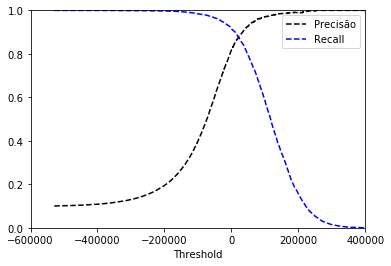

In [444]:
plt.plot(thresValue, precValue[:-1], "k--", label="Precisão")
plt.plot(thresValue, recValue[:-1], "b--", label="Recall")
plt.xlabel("Threshold")
plt.ylim([0,1])
plt.xlim([-600000,400000])
plt.legend(loc="upper right")

(0, 1)

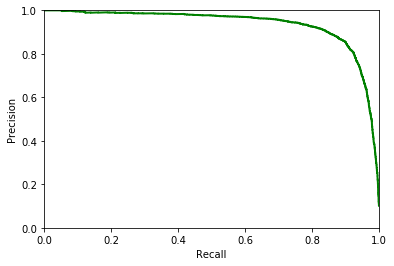

In [445]:
plt.plot(recValue, precValue, "g", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0,1])
plt.ylim([0,1])

### Confusion Matrix 2x2

In [446]:
x = confusion_matrix(Y_predCrossed, Y_train_is4)
x

array([[53132,   616],
       [ 1026,  5226]], dtype=int64)

### ROC curve

In [449]:
fpr, tpr, roc_thresholds = roc_curve(Y_train_is4, Y_predDecision)

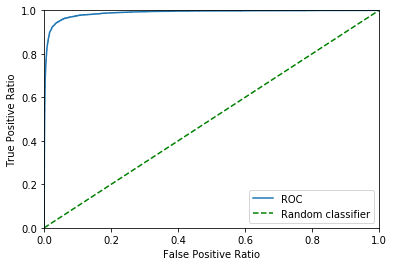

In [461]:
plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1],[0,1],"g--", label="Random classifier")
plt.axis([0,1,0,1])
plt.xlabel("False Positive Ratio")
plt.ylabel("True Positive Ratio")
plt.legend(loc="lower right")

In [465]:
x = roc_auc_score(Y_train_is4, Y_predDecision)
x

0.9884469324851541

# Multi-Classifier: 0 to 9

In [479]:
multiSGDClassifier = SGDClassifier(random_state=42, tol=-np.infty, max_iter=10)

multiSGDClassifier.fit(X_train, Y_train)
Y_multiPred = multiSGDClassifier.predict(X_test)

In [481]:
predPrec = precision_score(Y_multiPred, Y_test, average="macro")
predPrec

0.8368463466142739

In [489]:
some_digit_scores = multiSGDClassifier.decision_function([some_digit])
some_digit_scores
#Observar que o valor da decision_function para o 4 é 157663, o maior de todos
#Para multiclassificadores, a decision function tem como output um valor para cada label possível

array([[-289127.32220745, -253137.49525497, -167446.14207087,
        -244329.02039446,  157663.75409634,  -35872.16528989,
        -142887.99842483, -113895.16303114, -139361.80957757,
        -182230.96584084]])

### Extra: efeito de dimensionar as entradas

In [491]:
cross_val_score(multiSGDClassifier, X_train, Y_train, cv=3, scoring="accuracy")

array([0.8546, 0.836 , 0.8717])

In [493]:
scaler = StandardScaler()

In [495]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [496]:
cross_val_score(multiSGDClassifier, X_train_scaled, Y_train, cv=3, scoring="accuracy")

array([0.90625, 0.90815, 0.91245])

### One Vs One Classifier

In [483]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))

In [484]:
ovo_clf.fit(X_train, Y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

In [485]:
ovo_clf.predict([some_digit])

array(['4'], dtype=object)

In [486]:
# (10 * 9)/2 = 45 classificadores binários
len(ovo_clf.estimators_)

45

### Confusion Matrix multi-classifier

In [497]:
y_train_pred = cross_val_predict(multiSGDClassifier, X_train_scaled, Y_train, cv=3)
conf_matrix = confusion_matrix(Y_train, y_train_pred)
conf_matrix

array([[5715,    2,   29,    9,   12,   47,   46,    8,   52,    3],
       [   1, 6461,   37,   29,    7,   41,    9,   10,  133,   14],
       [  52,   36, 5314,  107,   79,   29,   92,   55,  179,   15],
       [  44,   39,  140, 5340,    3,  239,   33,   51,  143,   99],
       [  18,   21,   37,   10, 5338,    9,   59,   27,  110,  213],
       [  70,   37,   40,  193,   75, 4598,  101,   25,  185,   97],
       [  32,   22,   45,    2,   42,   95, 5629,    3,   48,    0],
       [  23,   23,   68,   32,   56,   11,    4, 5771,   22,  255],
       [  47,  130,   66,  147,   10,  155,   49,   26, 5093,  128],
       [  37,   29,   26,   88,  150,   34,    2,  201,  104, 5278]],
      dtype=int64)

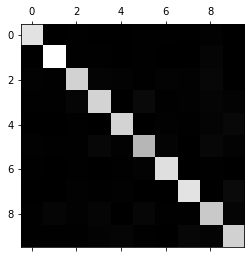

In [499]:
plt.matshow(conf_matrix, cmap=plt.cm.gray)
plt.show()

In [504]:
row_sums = conf_matrix.sum(axis=1, keepdims=True)

In [505]:
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]], dtype=int64)

In [506]:
norm_conf_matrix = conf_matrix / row_sums

In [509]:
np.fill_diagonal(norm_conf_matrix,0)

In [43]:
plt.matshow(norm_conf_matrix, cmap=plt.cm.gray)

#Removendo a influência da diagonal, mostrando assim os vieses que ocorreram na classificação
#Notar que 8 e 9 estarem 'mais brancos' é pq há mais erros aqui! (falsas classificações como 8 e 9)

NameError: name 'norm_conf_matrix' is not defined